In [1]:
import sys
print(sys.executable)

/home/is/lathifgalih-k/miniconda3/envs/myenv/bin/python


In [2]:
import os
os.getcwd()

'/home/is/lathifgalih-k/research_naist/multimodal-clone'

### Function and Code for Audio Preprocessing

In [6]:
import os
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import medfilt
import matplotlib.pyplot as plt
from pathlib import Path

def simple_vad(audio, sr, frame_length=2048, hop_length=512, energy_threshold=0.0001):
    """
    Simple VAD based on energy threshold
    """
    # Calculate short-time energy
    frame_energy = []
    for i in range(0, len(audio) - frame_length, hop_length):
        frame = audio[i:i + frame_length]
        energy = np.sum(frame ** 2)
        frame_energy.append(energy)
    
    frame_energy = np.array(frame_energy)
    
    # Normalize energy
    if np.max(frame_energy) > 0:
        frame_energy = frame_energy / np.max(frame_energy)
    
    # Apply median filter to smooth the energy curve
    frame_energy = medfilt(frame_energy, kernel_size=5)
    
    # Determine voice activity
    voice_frames = frame_energy > energy_threshold
    
    return voice_frames, frame_energy

def extract_voice_segments(audio, voice_frames, hop_length=512, min_segment_length=0.1, sr=22050):
    """
    Extract voice segments from audio based on VAD results
    """
    # Convert frame indices to sample indices
    voice_samples = np.zeros(len(audio), dtype=bool)
    
    for i, is_voice in enumerate(voice_frames):
        start_sample = i * hop_length
        end_sample = min(start_sample + hop_length, len(audio))
        if is_voice:
            voice_samples[start_sample:end_sample] = True
    
    # Find continuous voice segments
    segments = []
    start = None
    
    for i, is_voice in enumerate(voice_samples):
        if is_voice and start is None:
            start = i
        elif not is_voice and start is not None:
            # End of segment
            if (i - start) / sr >= min_segment_length:  # Minimum segment length
                segments.append((start, i))
            start = None
    
    # Handle case where audio ends with voice
    if start is not None:
        if (len(voice_samples) - start) / sr >= min_segment_length:
            segments.append((start, len(voice_samples)))
    
    return segments

### Preprocesing ALS audio dataset

Because als audio dataset have so much silence region, we use VAD or voice activation detection to get the non silence wav form of the speech

In [5]:
# Set up paths
audio_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/ALS/Audios"
output_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/ALS/Processed_Audios"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def process_audio_als(file_path, output_path, energy_threshold=0.0001):
    """
    Process single audio file with VAD
    """
    # Load audio
    audio, sr = librosa.load(file_path, sr=None)
    print(f"Processing: {os.path.basename(file_path)}")
    print(f"Original length: {len(audio)/sr:.2f} seconds")
    
    # Apply VAD
    voice_frames, frame_energy = simple_vad(audio, sr, energy_threshold=energy_threshold)
    
    # Extract voice segments
    segments = extract_voice_segments(audio, voice_frames, sr=sr)
    
    if segments:
        # Concatenate all voice segments
        voice_audio = []
        for start, end in segments:
            start_segment = round(start/sr,2)
            end_segment = round(end/sr,2)
            voice_audio.extend(audio[start:end])

        voice_audio = np.array(voice_audio)
        # clean noise after checking the files segment
        if "A008" in file_path:
            start_time = 13.8  # Trim audio before 13.8 seconds for A008 files
        elif "A011" in file_path:
            start_time = 1.5  # Trim audio before 1.5 seconds for A011 files
        elif "A014" in file_path:
            start_time = 3.2  # Trim audio before 3.2 seconds for A014 files
        elif "A016" in file_path:
            start_time = 1.5  # Trim audio before 1.5 seconds for A016 files
        elif "A017" in file_path:
            start_time = 2.0  # Trim audio before 2 seconds for A017 files
        else:
            start_time = 0.0

        start_sample = int(start_time * sr)
        voice_audio = voice_audio[start_sample:]
        print(f"Processed length: {len(voice_audio)/sr:.2f} seconds")
        print(f"Silence removed: {(len(audio) - len(voice_audio))/sr:.2f} seconds")
        
        # Save processed audio
        sf.write(output_path, voice_audio, sr)
        
        return voice_audio, sr, segments
    else:
        print("No voice segments detected!")
        return None, sr, []

# Get first all BBP_NORMAL files that have sound
bbp_normal_files = []
for file in os.listdir(audio_dir):
    if "BBP_NORMAL" in file.upper() and file.endswith('.wav') and "A009" not in file.upper():
        bbp_normal_files.append(file)

# Process first n files
sample_files = bbp_normal_files
print(f"Found {len(bbp_normal_files)} BBP_NORMAL files")
print(f"Processing first {len(sample_files)}: {sample_files}")

for file_name in sample_files:
    input_path = os.path.join(audio_dir, file_name)
    output_path = os.path.join(output_dir, f"clean_{file_name}")
    
    try:
        processed_audio, sr, segments = process_audio_als(input_path, output_path)
        print(f"Saved: {output_path}")
        print(f"Voice segments: {len(segments)}")
        print("-" * 50)
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        print("-" * 50)

Found 8 BBP_NORMAL files
Processing first 8: ['A006_02_BBP_NORMAL_al.wav', 'A014_02_BBP_Normal.wav', 'A011_02_BBP_NORMAL.wav', 'A017_02_BBP_Normal.wav', 'A002_02_BBP_NORMAL.wav', 'A010_02_BBP_NORMAL.wav', 'A008_02_BBP_NORMAL.wav', 'A016_02_BBP_Normal.wav']
Processing: A006_02_BBP_NORMAL_al.wav
Original length: 33.15 seconds
Processed length: 21.80 seconds
Silence removed: 11.34 seconds
Saved: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/ALS/Processed_Audios/clean_A006_02_BBP_NORMAL_al.wav
Voice segments: 26
--------------------------------------------------
Processing: A014_02_BBP_Normal.wav
Original length: 25.02 seconds
Processed length: 21.78 seconds
Silence removed: 3.24 seconds
Saved: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/ALS/Processed_Audios/clean_A014_02_BBP_Normal.wav
Voice segments: 1
--------------------------------------------------
Processing: A011_02_BBP_NORMAL.wav
Original length: 30.29 seconds
Processed length: 2

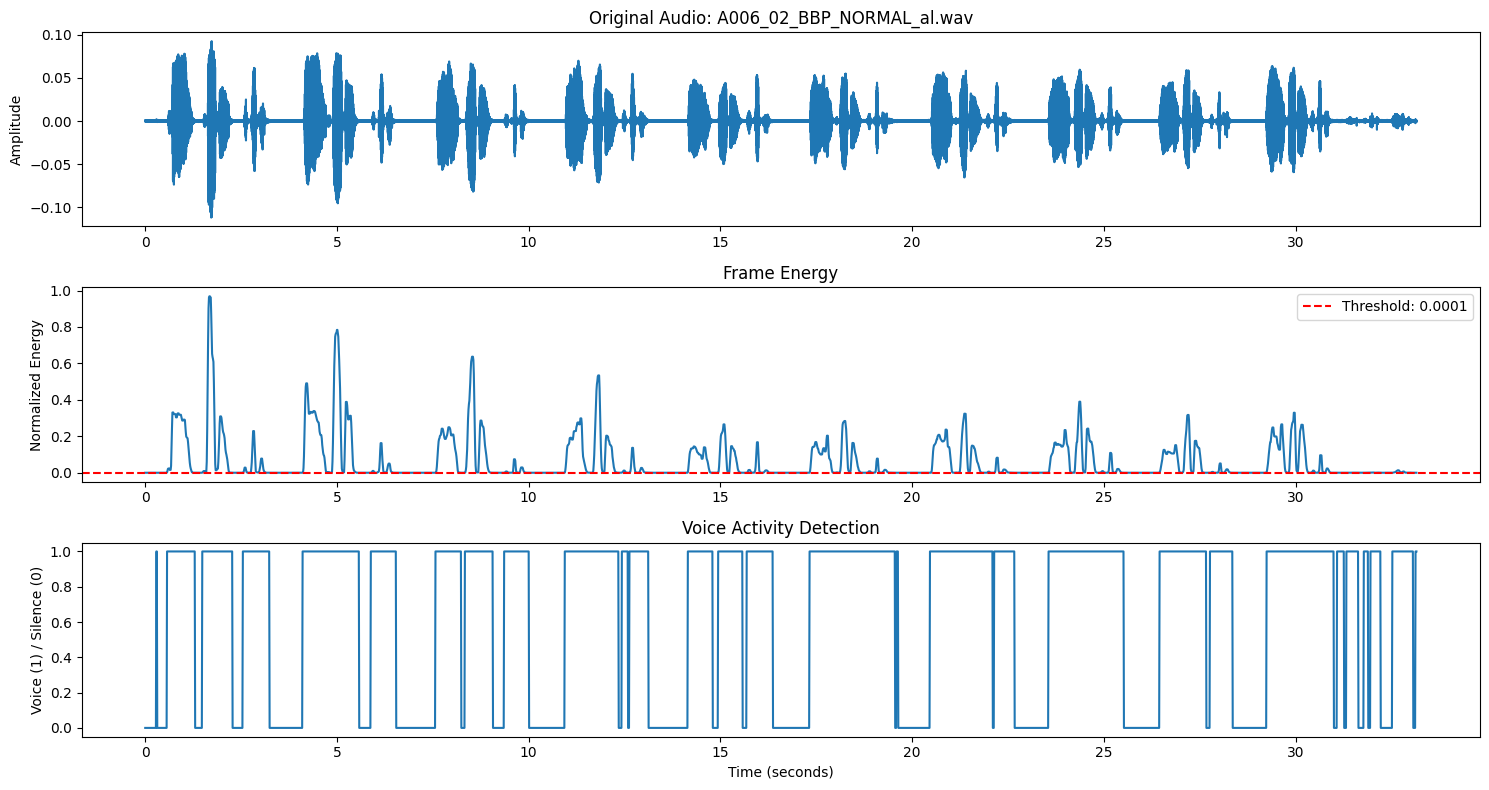

In [6]:
# Optional: Visualize VAD results for one file
def visualize_vad_results(file_path, energy_threshold=0.0001):
    """
    Visualize the VAD results
    """
    audio, sr = librosa.load(file_path, sr=None)
    voice_frames, frame_energy = simple_vad(audio, sr, energy_threshold=energy_threshold)
    
    # Create time axis
    time_audio = np.linspace(0, len(audio)/sr, len(audio))
    time_frames = np.linspace(0, len(audio)/sr, len(frame_energy))
    
    plt.figure(figsize=(15, 8))
    
    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time_audio, audio)
    plt.title(f'Original Audio: {os.path.basename(file_path)}')
    plt.ylabel('Amplitude')
    
    # Plot energy
    plt.subplot(3, 1, 2)
    plt.plot(time_frames, frame_energy)
    plt.axhline(y=energy_threshold, color='r', linestyle='--', label=f'Threshold: {energy_threshold}')
    plt.title('Frame Energy')
    plt.ylabel('Normalized Energy')
    plt.legend()
    
    # Plot VAD decision
    plt.subplot(3, 1, 3)
    plt.plot(time_frames, voice_frames.astype(int))
    plt.title('Voice Activity Detection')
    plt.ylabel('Voice (1) / Silence (0)')
    plt.xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

# Visualize the first file
if sample_files:
    first_file = os.path.join(audio_dir, sample_files[0])
    visualize_vad_results(first_file)

### Preprocesing Stroke Audio dataset

Because Stroke dataset have more than one speaker speakinng, we clean to get the energy on some threshold to get the patients wav form of the speech for audio except S001 and S002. For s001 and s002 need use speaker diarization.

#### Preproces Audio by Energy

In [7]:
# Set up paths
audio_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Audios"
output_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def process_audio_stroke(file_path, output_path, energy_threshold=0.0001):
    """
    Process single audio file with VAD
    """
    # Load audio
    audio, sr = librosa.load(file_path, sr=None)
    print(f"Processing: {os.path.basename(file_path)}")
    print(f"Original length: {len(audio)/sr:.2f} seconds")
    
    # Apply VAD
    voice_frames, frame_energy = simple_vad(audio, sr, energy_threshold=energy_threshold)
    
    # Extract voice segments
    segments = extract_voice_segments(audio, voice_frames, sr=sr)
    
    if segments:
        # Concatenate all voice segments
        voice_audio = []
        for start, end in segments:
            start_segment = round(start/sr,2)
            end_segment = round(end/sr,2)
            print(f"Segment: {start_segment} - {end_segment} seconds")
            voice_audio.extend(audio[start:end])

        voice_audio = np.array(voice_audio)
        # clean noise after checking the files segment
        # if "A008" in file_path:
        #     start_time = 13.8  # Trim audio before 13.8 seconds for A008 files
        # elif "A011" in file_path:
        #     start_time = 1.5  # Trim audio before 1.5 seconds for A011 files
        # elif "A014" in file_path:
        #     start_time = 3.2  # Trim audio before 3.2 seconds for A014 files
        # elif "A016" in file_path:
        #     start_time = 1.5  # Trim audio before 1.5 seconds for A016 files
        # elif "A017" in file_path:
        #     start_time = 2.0  # Trim audio before 2 seconds for A017 files
        # else:
        #     start_time = 0.0

        # start_sample = int(start_time * sr)
        start_sample = 0  # Debugging: start from the beginning
        voice_audio = voice_audio[start_sample:]
        print(f"Processed length: {len(voice_audio)/sr:.2f} seconds")
        print(f"Silence removed: {(len(audio) - len(voice_audio))/sr:.2f} seconds")
        
        # Save processed audio
        sf.write(output_path, voice_audio, sr)
        
        return voice_audio, sr, segments
    else:
        print("No voice segments detected!")
        return None, sr, []

# Get first all BBP_NORMAL files that have sound
bbp_normal_files = []
for file in os.listdir(audio_dir):
    if "BBP_NORMAL" in file.upper() and file.endswith('.wav') and file.startswith("S"):
        bbp_normal_files.append(file)

# Process first n files
sample_files = bbp_normal_files
print(f"Found {len(bbp_normal_files)} BBP_NORMAL files")
print(f"Processing first {len(sample_files)}: {sample_files}")

for file_name in sample_files:
    input_path = os.path.join(audio_dir, file_name)
    output_path = os.path.join(output_dir, f"clean_{file_name}")
    
    try:
        processed_audio, sr, segments = process_audio_stroke(input_path, output_path, energy_threshold=0.001)
        print(f"Saved: {output_path}")
        print(f"Voice segments: {len(segments)}")
        print("-" * 50)
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        print("-" * 50)

Found 11 BBP_NORMAL files
Processing first 11: ['S006_02_BBP_NORMAL.wav', 'S013_02_BBP_NORMAL.wav', 'S001_02_BBP_NORMAL.wav', 'S007_02_BBP_NORMAL.wav', 'S012_02_BBP_NORMAL.wav', 'S002_02_BBP_NORMAL.wav', 'S009_02_BBP_NORMAL.wav', 'S011_02_BBP_NORMAL.wav', 'S008_02_BBP_NORMAL.wav', 'S003_02_BBP_NORMAL.wav', 'S005_02_BBP_NORMAL.wav']
Processing: S006_02_BBP_NORMAL.wav
Original length: 37.55 seconds
Segment: 0.0 - 1.11 seconds
Segment: 1.17 - 1.31 seconds
Segment: 1.54 - 6.0 seconds
Segment: 6.04 - 9.39 seconds
Segment: 9.43 - 11.27 seconds
Segment: 11.31 - 12.23 seconds
Segment: 12.26 - 12.43 seconds
Segment: 12.48 - 14.51 seconds
Segment: 14.55 - 15.26 seconds
Segment: 15.29 - 15.39 seconds
Segment: 15.43 - 17.41 seconds
Segment: 17.48 - 19.81 seconds
Segment: 19.84 - 24.11 seconds
Segment: 24.13 - 24.67 seconds
Segment: 24.71 - 27.05 seconds
Segment: 27.11 - 32.86 seconds
Segment: 33.15 - 33.65 seconds
Segment: 33.68 - 37.4 seconds
Processed length: 36.28 seconds
Silence removed: 1.27 

#### Preproces Audio by Diarization

In [16]:
import torch
import torchaudio
from pyannote.audio import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

def perform_speaker_diarization(audio_path, output_rttm_path=None, num_speakers=2):
    """
    Perform speaker diarization on audio file from pyannonate huggingface pipeline
    """
    # Load environment variables
    load_dotenv()

    # Get Hugging Face token
    HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

    if not HUGGINGFACE_TOKEN:
        raise ValueError("Please set the HUGGINGFACE_TOKEN environment variable.")
    
    # Load the pre-trained speaker diarization pipeline
    try:
        pipeline = Pipeline.from_pretrained(
            "pyannote/speaker-diarization-3.1",
            use_auth_token=HUGGINGFACE_TOKEN
        )
        print("Pipeline loaded successfully")
        
        # Move to GPU if available and efficient
        if torch.cuda.is_available():
            pipeline = pipeline.to(torch.device("cuda"))
            print("Using GPU for diarization")
        else:
            print("Using CPU for diarization")
        
        # print(f"Audio file: {audio_path}")
       
        # Start processing diarization
        print(f"Processing diarization for {audio_path}")
        if num_speakers is not None:
            diarization = pipeline(audio_path, num_speakers=num_speakers)
        else:
            diarization = pipeline(audio_path)

        # Save RTTM
        if output_rttm_path is not None:
            with open(output_rttm_path, 'w') as rttm_file:
                diarization.write_rttm(rttm_file)
            print(f"RTTM file saved to {output_rttm_path}")

        return diarization

    except Exception as e:
        print(f"Error making diarization: {e}")
        return None

def visualize_diarization(audio_file_path, diarization):
    """
    Visualize audio waveform with speaker diarization results
    """
    # Load audio for visualization
    waveform, sample_rate = torchaudio.load(audio_file_path)
    waveform = waveform.squeeze().numpy()
    
    # Create time axis
    time_axis = np.linspace(0, len(waveform) / sample_rate, len(waveform))
    
    plt.figure(figsize=(15, 8))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, waveform)
    plt.title(f'Audio Waveform: {os.path.basename(audio_file_path)}')
    plt.ylabel('Amplitude')
    
    # Plot diarization
    plt.subplot(2, 1, 2)
    speakers = list(diarization.labels())
    colors = plt.cm.Set3(np.linspace(0, 1, len(speakers)))
    
    for segment, track, speaker in diarization.itertracks(yield_label=True):
        speaker_idx = speakers.index(speaker)
        plt.barh(speaker_idx, segment.duration, left=segment.start, 
                color=colors[speaker_idx], alpha=0.7, label=speaker if speaker not in plt.gca().get_legend_handles_labels()[1] else "")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Speaker')
    plt.title('Speaker Diarization')
    plt.yticks(range(len(speakers)), speakers)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def extract_speaker_segments(audio_path, diarization, target_speaker=None):
    """
    Extract segments for a specific speaker or all speakers
    """
    # Load audio
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.squeeze().numpy()

    speaker_segments = {}
    for segment, _, speaker in diarization.itertracks(yield_label=True):
        if target_speaker is None or speaker == target_speaker:
            start_sample = int(segment.start * sample_rate)
            end_sample = int(segment.end * sample_rate)
            
            if speaker not in speaker_segments:
                speaker_segments[speaker] = []
            
            speaker_segments[speaker].append({
                'audio': waveform[start_sample:end_sample],
                'start_time': segment.start,
                'end_time': segment.end,
                'duration': segment.duration
            })
    
    return speaker_segments

Processing diarization for S001_02_BBP_NORMAL.wav
Pipeline loaded successfully
Using GPU for diarization
Processing diarization for /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Audios/S001_02_BBP_NORMAL.wav


/home/is/lathifgalih-k/miniconda3/envs/myenv/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


RTTM file saved to /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Diarization_Outputs/S001_02_BBP_NORMAL.rttm
Diarization Results:
Speaker: SPEAKER_01, Start: 0.30s, End: 1.03s, Duration: 0.73s
Speaker: SPEAKER_00, Start: 1.03s, End: 1.28s, Duration: 0.25s
Speaker: SPEAKER_00, Start: 2.04s, End: 2.06s, Duration: 0.02s
Speaker: SPEAKER_01, Start: 2.16s, End: 2.85s, Duration: 0.69s
Speaker: SPEAKER_00, Start: 2.61s, End: 6.33s, Duration: 3.71s
Speaker: SPEAKER_01, Start: 3.91s, End: 4.27s, Duration: 0.35s
Speaker: SPEAKER_01, Start: 5.08s, End: 5.28s, Duration: 0.20s
Speaker: SPEAKER_01, Start: 5.46s, End: 5.75s, Duration: 0.29s
Speaker: SPEAKER_00, Start: 7.41s, End: 12.33s, Duration: 4.93s
Speaker: SPEAKER_01, Start: 10.58s, End: 11.86s, Duration: 1.28s
Speaker: SPEAKER_00, Start: 12.94s, End: 16.97s, Duration: 4.03s
Speaker: SPEAKER_01, Start: 13.21s, End: 13.92s, Duration: 0.71s
Speaker: SPEAKER_01, Start: 13.95s, End: 14.00s, Duration:

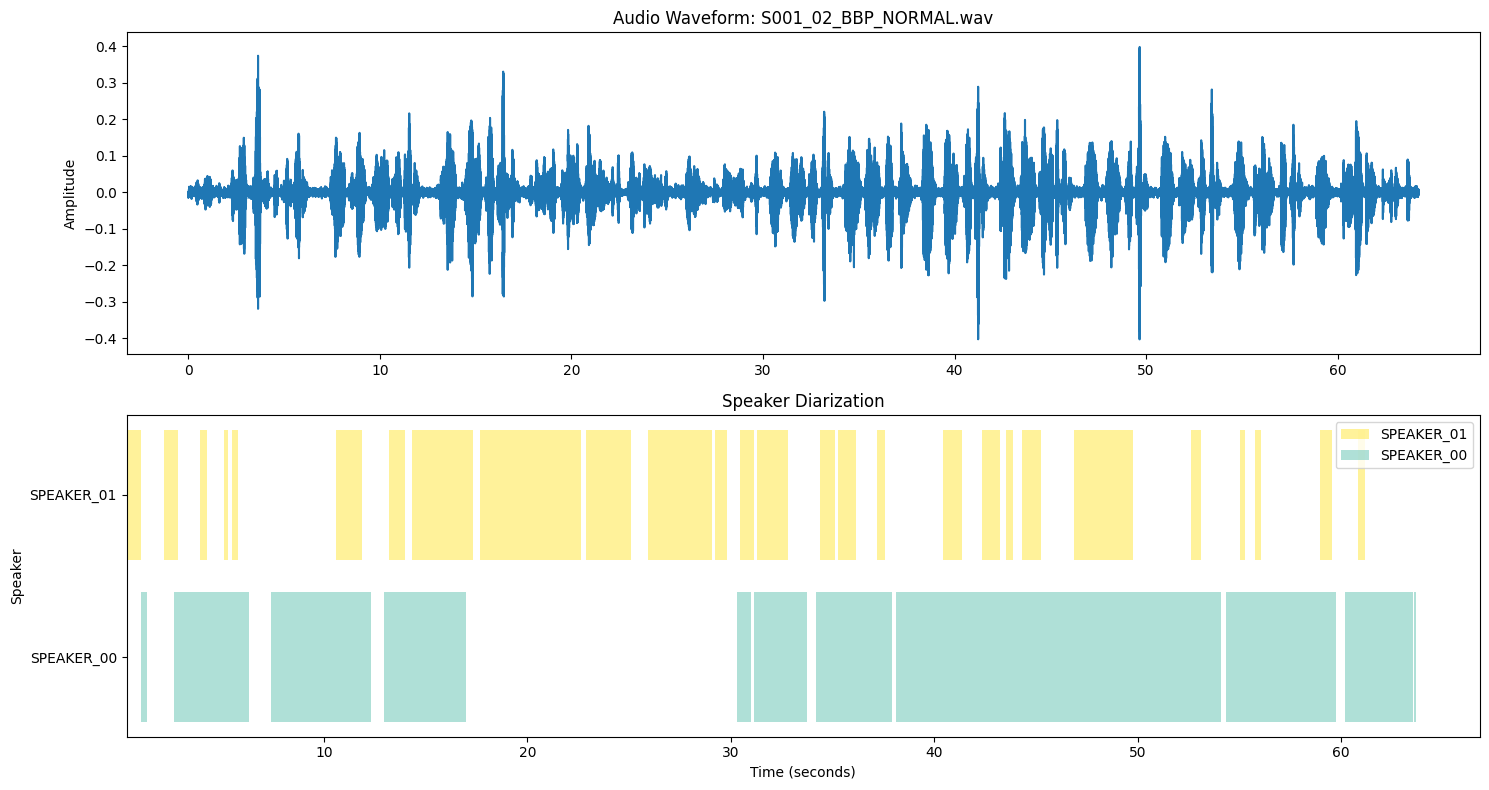

Speaker: SPEAKER_01, Number of segments: 29
Segments: [(0.30096875, 1.0265937500000002), (2.15721875, 2.84909375), (3.91221875, 4.26659375), (5.076593750000001, 5.2790937499999995), (5.464718750000001, 5.75159375), (10.57784375, 11.860343750000002), (13.21034375, 13.919093750000002), (13.952843750000003, 14.00346875), (14.30721875, 17.32784375), (17.66534375, 22.62659375), (22.86284375, 25.07346875), (25.91721875, 29.07284375), (29.24159375, 29.79846875), (30.473468750000002, 31.16534375), (31.300343750000003, 32.81909375), (34.40534375, 35.11409375), (35.282843750000005, 36.143468750000004), (37.189718750000004, 37.57784375), (40.41284375, 41.37471875), (42.37034375, 43.23096875), (43.517843750000004, 43.85534375), (44.29409375, 45.23909375), (46.85909375, 47.60159375), (47.618468750000005, 49.79534375), (52.64721875, 53.119718750000004), (55.02659375, 55.29659375000001), (55.78596875, 56.055968750000005), (58.97534375, 59.56596875), (60.84846875, 61.16909375)]
Saved SPEAKER_01 audio:

/home/is/lathifgalih-k/miniconda3/envs/myenv/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


RTTM file saved to /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Diarization_Outputs/S002_02_BBP_NORMAL.rttm
Diarization Results:
Speaker: SPEAKER_01, Start: 0.54s, End: 0.81s, Duration: 0.27s
Speaker: SPEAKER_01, Start: 1.52s, End: 2.06s, Duration: 0.54s
Speaker: SPEAKER_01, Start: 2.66s, End: 3.05s, Duration: 0.39s
Speaker: SPEAKER_01, Start: 3.46s, End: 4.08s, Duration: 0.62s
Speaker: SPEAKER_01, Start: 4.49s, End: 5.30s, Duration: 0.81s
Speaker: SPEAKER_01, Start: 5.50s, End: 5.92s, Duration: 0.42s
Speaker: SPEAKER_01, Start: 6.70s, End: 6.81s, Duration: 0.12s
Speaker: SPEAKER_01, Start: 7.30s, End: 7.96s, Duration: 0.66s
Speaker: SPEAKER_01, Start: 8.57s, End: 9.04s, Duration: 0.47s
Speaker: SPEAKER_01, Start: 10.12s, End: 11.22s, Duration: 1.10s
Speaker: SPEAKER_01, Start: 12.50s, End: 13.02s, Duration: 0.52s
Speaker: SPEAKER_01, Start: 13.36s, End: 13.70s, Duration: 0.34s
Speaker: SPEAKER_01, Start: 14.02s, End: 15.20s, Duration: 

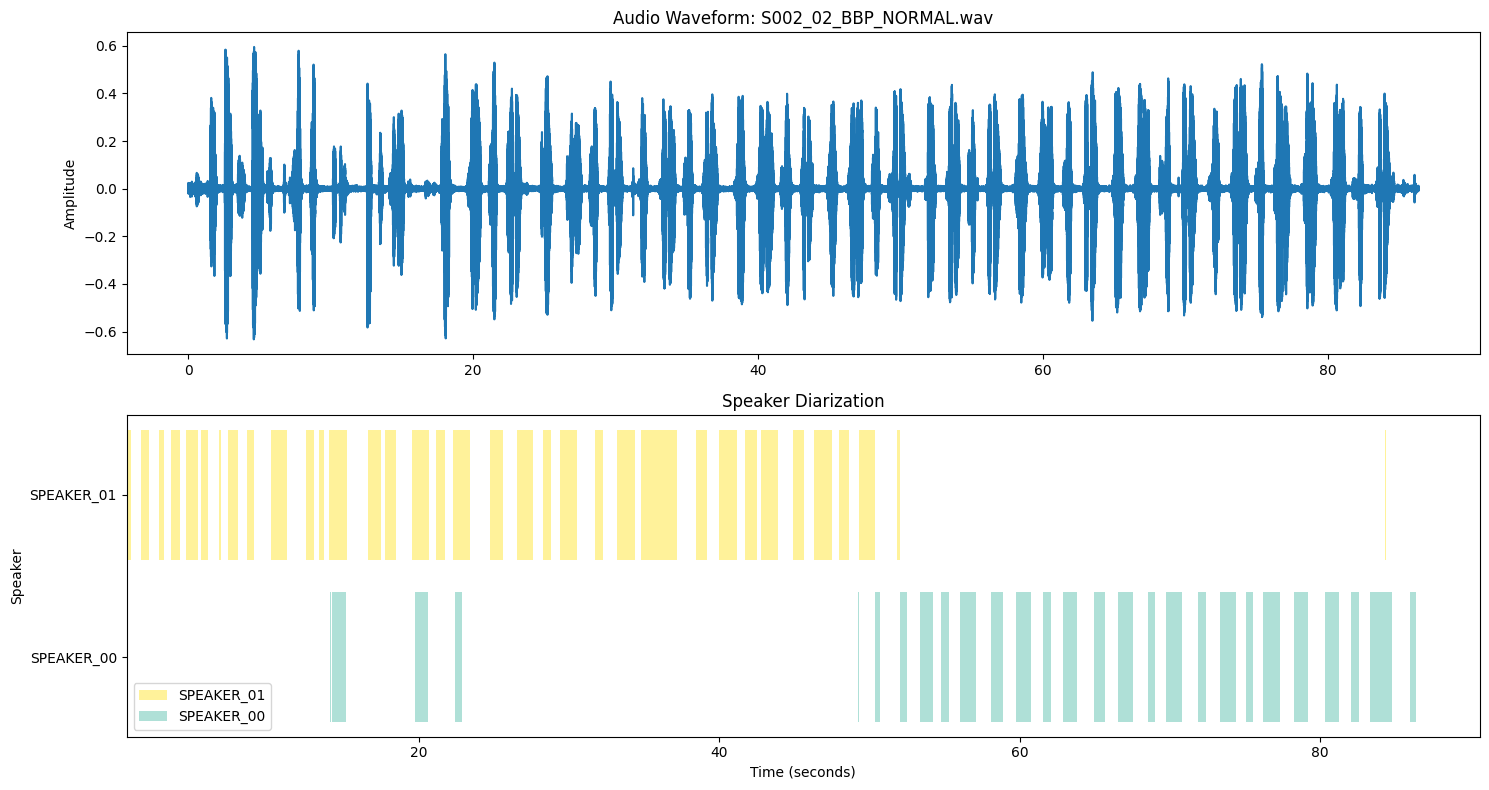

Speaker: SPEAKER_01, Number of segments: 36
Segments: [(0.5372187500000001, 0.8072187500000001), (1.51596875, 2.0559687500000003), (2.6634687500000003, 3.0515937500000003), (3.45659375, 4.08096875), (4.48596875, 5.29596875), (5.498468750000001, 5.920343750000001), (6.69659375, 6.814718750000001), (7.30409375, 7.96221875), (8.56971875, 9.04221875), (10.122218750000002, 11.219093750000003), (12.501593750000001, 13.024718750000002), (13.36221875, 13.699718750000002), (14.020343750000002, 15.20159375), (16.61909375, 17.445968750000002), (17.73284375, 18.44159375), (19.555343750000002, 20.63534375), (21.12471875, 21.69846875), (22.28909375, 23.402843750000002), (24.73596875, 25.562843750000003), (26.52471875, 27.621593750000002), (28.27971875, 28.76909375), (29.39346875, 30.50721875), (31.70534375, 32.27909375), (33.173468750000005, 34.37159375), (34.759718750000005, 37.20659375), (38.47221875, 39.180968750000005), (39.940343750000004, 41.15534375), (41.712218750000005, 42.48846875), (42.75

In [17]:
# Process stroke audio diarization on files s001 and s002
stroke_files = ["S001_02_BBP_NORMAL.wav", "S002_02_BBP_NORMAL.wav"]
diarization_output_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Diarization_Outputs"
os.makedirs(diarization_output_dir, exist_ok=True)

for file_name in stroke_files:
    input_path = os.path.join(audio_dir, file_name)
    if os.path.exists(input_path):
        print(f"Processing diarization for {file_name}")
    
        # Set up output RTTM
        rttm_output_path = os.path.join(diarization_output_dir, f"{file_name.replace('.wav', '.rttm')}")
        # print("CEK")
        # Perform diarization
        diarization = perform_speaker_diarization(
            input_path,
            rttm_output_path,
            num_speakers=2 # Patient and Examiner
        )
        # print("CEK2")
        if diarization is not None:
            print("Diarization Results:")
            for segment, track, speaker in diarization.itertracks(yield_label=True):
                print(f"Speaker: {speaker}, Start: {segment.start:.2f}s, End: {segment.end:.2f}s, Duration: {segment.duration:.2f}s")

            # Visualize diarization
            visualize_diarization(input_path, diarization)

            # Extract segments for each speaker and save individual speaker
            speaker_segments = extract_speaker_segments(input_path, diarization)
            for speaker, segments in speaker_segments.items():
                print(f"Speaker: {speaker}, Number of segments: {len(segments)}")
                print(f"Segments: {[(seg['start_time'], seg['end_time']) for seg in segments]}")

                # Concatenate all segments for this speaker
                speaker_audio = []
                for segment in segments:
                    speaker_audio.extend(segment['audio'])
                
                if speaker_audio:
                    speaker_audio = np.array(speaker_audio)
                    speaker_output_path = os.path.join(
                        diarization_output_dir, 
                        f"{file_name.replace('.wav', '')}_{speaker}.wav"
                    )
                    
                    # Load original sample rate
                    _, sr = librosa.load(input_path, sr=None)
                    sf.write(speaker_output_path, speaker_audio, sr)
                    print(f"Saved {speaker} audio: {speaker_output_path}")
                    print(f"Duration: {len(speaker_audio)/sr:.2f} seconds")

        print("-" * 50)
    else:
        print(f"File not found: {input_path}")

#### Preproces Audio by Speech Separation

In [7]:
import torch
import torchaudio
from pyannote.audio import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

def perform_speech_separation(audio_path, output_dir):
    """
    Perform speech separation on audio file using pyannote speech separation pipeline
    """
    # Load environment variables
    load_dotenv()

    # Get Hugging Face token
    HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

    if not HUGGINGFACE_TOKEN:
        raise ValueError("Please set the HUGGINGFACE_TOKEN environment variable.")
    
    # Load the pre-trained speech separation pipeline if not provided
    try:
        pipeline = Pipeline.from_pretrained(
            "pyannote/speech-separation-ami-1.0",
            use_auth_token=HUGGINGFACE_TOKEN
        )
        print("Speech separation pipeline loaded successfully")
        
        # Move to GPU if available
        if torch.cuda.is_available():
            pipeline = pipeline.to(torch.device("cuda"))
            print("Using GPU for speech separation")
        else:
            print("Using CPU for speech separation")
    except Exception as e:
        print(f"Error loading pipeline: {e}")
        return None, None, None

    try:
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Processing speech separation for {audio_path}")
        
        # Load audio and get original sample rate
        waveform, original_sample_rate = torchaudio.load(audio_path)
        print(f"Loaded audio: {audio_path}, Sample rate: {original_sample_rate}, Shape: {waveform.shape}")

        # Resample to 16000 Hz if necessary
        target_sample_rate = 16000
        resampler = torchaudio.transforms.Resample(original_sample_rate, target_sample_rate)
        waveform_resampled = resampler(waveform)

        # Process with original sample rate
        diarization, sources = pipeline({"waveform": waveform_resampled, "sample_rate": target_sample_rate})

        # Check the actual number of speakers detected
        num_speakers_detected = sources.data.shape[1] if sources is not None else 0
        print(f"Number of speakers detected: {num_speakers_detected}")
        print(f"Sources shape: {sources.data.shape}")

        # Save RTTM file
        base_name = os.path.splitext(os.path.basename(audio_path))[0]
        rttm_output_path = os.path.join(output_dir, f"{base_name}_separation.rttm")
        with open(rttm_output_path, "w") as rttm:
            diarization.write_rttm(rttm)
        print(f"RTTM file saved to {rttm_output_path}")

        # Save separated sources as individual wav files with ORIGINAL sample rate
        saved_files = []
        for s in range(num_speakers_detected):
            speaker_label = f"SPEAKER_{s:02d}"
            speaker_output_path = os.path.join(output_dir, f"{base_name}_{speaker_label}.wav")
            
            # Ensure we don't go out of bounds
            if s < sources.data.shape[1]:
                # Use original sample rate instead of hardcoded 44100
                sf.write(speaker_output_path, sources.data[:, s], target_sample_rate)
                saved_files.append(speaker_output_path)
                print(f"Saved separated audio for {speaker_label}: {speaker_output_path}")
            else:
                print(f"Warning: Speaker {speaker_label} not found in sources")

        return diarization, sources, saved_files

    except Exception as e:
        print(f"Error during speech separation: {e}")
        return None, None, None
    
def visualize_separation(audio_file_path, diarization, sources):
    """
    Visualize original audio, diarization, and separated sources
    """
    # Load original audio for visualization
    waveform, sample_rate = torchaudio.load(audio_file_path)
    waveform = waveform.squeeze().numpy()
    
    # Create time axis
    time_axis = np.linspace(0, len(waveform) / sample_rate, len(waveform))
    
    # Number of speakers
    num_speakers = len(diarization.labels())
    
    plt.figure(figsize=(15, 4 + 2 * num_speakers))
    
    # Plot original waveform
    plt.subplot(num_speakers + 2, 1, 1)
    plt.plot(time_axis, waveform)
    plt.title(f'Original Audio: {os.path.basename(audio_file_path)}')
    plt.ylabel('Amplitude')
    
    # Plot diarization
    plt.subplot(num_speakers + 2, 1, 2)
    speakers = list(diarization.labels())
    colors = plt.cm.Set3(np.linspace(0, 1, len(speakers)))
    
    for segment, track, speaker in diarization.itertracks(yield_label=True):
        speaker_idx = speakers.index(speaker)
        plt.barh(speaker_idx, segment.duration, left=segment.start, 
                color=colors[speaker_idx], alpha=0.7, 
                label=speaker if speaker not in plt.gca().get_legend_handles_labels()[1] else "")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Speaker')
    plt.title('Speaker Diarization')
    plt.yticks(range(len(speakers)), speakers)
    plt.legend()
    
    # Plot separated sources
    sources_time_axis = np.linspace(0, sources.data.shape[0] / 16000, sources.data.shape[0])
    
    for s, speaker in enumerate(speakers):
        plt.subplot(num_speakers + 2, 1, 3 + s)
        plt.plot(sources_time_axis, sources.data[:, s])
        plt.title(f'Separated Source: {speaker}')
        plt.ylabel('Amplitude')
        if s == len(speakers) - 1:
            plt.xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Set up paths
audio_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios"
separation_output_dir = "/home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation"

# Create output directory
os.makedirs(separation_output_dir, exist_ok=True)

# Process specific stroke files that need separation
stroke_files = ["clean_S001_02_BBP_NORMAL.wav", "clean_S002_02_BBP_NORMAL.wav"]

for file_name in stroke_files:
    input_path = os.path.join(audio_dir, file_name)
    if os.path.exists(input_path):
        print(f"Processing speech separation for {file_name}")
        
        # Get original sample rate for duration calculation
        _, original_sr = torchaudio.load(input_path)
        
        # Perform speech separation
        diarization, sources, saved_files = perform_speech_separation(
            input_path, 
            separation_output_dir, 
        )
        
        if diarization is not None and sources is not None:
            print("Speech Separation Results:")
            for segment, track, speaker in diarization.itertracks(yield_label=True):
                print(f"Speaker: {speaker}, Start: {segment.start:.2f}s, End: {segment.end:.2f}s, Duration: {segment.duration:.2f}s")
            
            print(f"Separated audio files: {saved_files}")
            
            # Visualize results
            # visualize_separation(input_path, diarization, sources)

            # Print statistics - use ORIGINAL sample rate for duration calculation
            num_speakers = sources.data.shape[1]
            for s in range(num_speakers):
                speaker_label = f"SPEAKER_{s:02d}"
                duration_seconds = len(sources.data[:, s]) / original_sr  # Use original sample rate
                print(f"Speaker {speaker_label}: {duration_seconds:.2f} seconds")
            
        print("-" * 60)
    else:
        print(f"File not found: {input_path}")

Processing speech separation for clean_S001_02_BBP_NORMAL.wav


Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--separation-ami-1.0/snapshots/4d38e95cfd067c894b8b60b00761831fb01e4a8c/pytorch_model.bin`


Speech separation pipeline loaded successfully
Using GPU for speech separation
Processing speech separation for /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/clean_S001_02_BBP_NORMAL.wav
Loaded audio: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/clean_S001_02_BBP_NORMAL.wav, Sample rate: 44100, Shape: torch.Size([1, 2302976])
Number of speakers detected: 2
Sources shape: (840001, 2)
RTTM file saved to /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation/clean_S001_02_BBP_NORMAL_separation.rttm
Saved separated audio for SPEAKER_00: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation/clean_S001_02_BBP_NORMAL_SPEAKER_00.wav
Saved separated audio for SPEAKER_01: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation/

Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--separation-ami-1.0/snapshots/4d38e95cfd067c894b8b60b00761831fb01e4a8c/pytorch_model.bin`


Speech separation pipeline loaded successfully
Using GPU for speech separation
Processing speech separation for /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/clean_S002_02_BBP_NORMAL.wav
Loaded audio: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/clean_S002_02_BBP_NORMAL.wav, Sample rate: 44100, Shape: torch.Size([1, 1886720])
Number of speakers detected: 1
Sources shape: (688001, 1)
RTTM file saved to /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation/clean_S002_02_BBP_NORMAL_separation.rttm
Saved separated audio for SPEAKER_00: /home/is/lathifgalih-k/research_naist/multimodal-clone/dataset-toronto/Stroke/Processed_Audios/Speech_Separation/clean_S002_02_BBP_NORMAL_SPEAKER_00.wav
Speech Separation Results:
Speaker: SPEAKER_00, Start: 0.10s, End: 43.01s, Duration: 42.90s
Speaker: SPEAKER_01, Start: 0.58s, End: 1.60s, Duration: 1.

In [9]:
# waveworm, sample_rate = torchaudio.load("dataset-toronto/Stroke/Processed_Audios/Speech_Separation/clean_S001_02_BBP_NORMAL_SPEAKER_00.wav")
# print(f"Waveform shape: {waveworm.shape}, Sample rate: {sample_rate}")

# waveworm, sample_rate = torchaudio.load("dataset-toronto/Stroke/Processed_Audios/clean_S001_02_BBP_NORMAL.wav")
# print(f"Waveform shape: {waveworm.shape}, Sample rate: {sample_rate}")

In [12]:
# import torch
# torch.cuda.empty_cache()
# print("Finished processing all audio files.")